<a href="https://colab.research.google.com/github/Pawopiiieee/FloraAPI/blob/main/topic_roberta_gg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab6.4-Topic-classification-BERT

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

In this notebook, we demonstrate how to fine-tune BERT for topic classification.

We will use the [simpletransformers library](https://simpletransformers.ai/):
 wrapper for the [huggingface transformers library](https://huggingface.co/) on PyTorch.

We are going to run the notebook on [colab](https://colab.research.google.com/?utm_source=scs-index), which has (limited) free access to GPUs.

You need to enable GPUs for the notebook:

* navigate to Edit → Notebook Settings
* select GPU from the Hardware Accelerator drop-down



### Install/import libraries

Install the simpletransformers library (restart your runtime after the installation)

In [ ]:
!pip install simpletransformers==0.65.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.6/312.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt
import seaborn as sn

Import [the 20 newsgroups text dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html).

The dataset contains around 18,000 newsgroups posts on 20 topics.

In [ ]:
# load only a sub-selection of the categories (4 in our case)
data = pd.read_csv('google-playstore.csv', usecols=['App Name', 'Category'])

In [ ]:
labels = ['Sports', 'Books & Reference','Entertainment']
filtered = data[data['Category'].isin(labels)]
filtered['Category'] = filtered['Category'].apply(lambda x: labels.index(x))
train = filtered.sample(2000)
print(train)

                                              App Name  Category
73084                   English to Malayalam and Hindi         1
109181                   أدعية جميلة عن رمضان بالصور‎‏         1
66640                           Learn how to tie knots         2
40628                                         KinoGals         2
119382                                  Pathbuilder 2e         2
...                                                ...       ...
87034                          Boxscore For Basketball         0
17546   Sponge Bob Mod and Map for Minecraft PE - MCPE         2
116244                      Mini Ice Age Conversations         2
111591                                  BarrasFMS PLUS         2
49581                                    Legacy Cinema         2

[2000 rows x 2 columns]


<ipython-input-4-b8b08da677c9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['Category'] = filtered['Category'].apply(lambda x: labels.index(x))


In [ ]:
test_vu = pd.read_table("sentiment-topic-test.tsv", usecols=["text", "topic"])

test_topic = ["sports","movie","book"]

test_vu['topic'] = test_vu['topic'].apply(lambda x: test_topic.index(x))

test_df = pd.DataFrame(test_vu)

print(test_df)

                                                text  topic
0  I wouldn't be caught dead watching the NFL if ...      0
1  Chris O'Donnell stated that while filming for ...      1
2  The whole game was a rollercoaster ride, but L...      0
3  Zendaya slayed in Dune 2, as she does in all h...      1
4  While my favorite player was playing this matc...      0
5  My uncle's brother's neighbor's cat's veterina...      2
6  He said that The Great Gatsby is the best nove...      2
7  I could not look away from this train wrck of ...      1
8  The film Everything Everywhere All At Once fol...      1
9  I just finished reading pride and prejudice wh...      2


### Data exploration

The target attribute is the integer index of the category:

Convert data to pandas dataframe

In [ ]:
print(len(train))
train.head(5)

2000


,App Name,Category
73084,English to Malayalam and Hindi,1
109181,أدعية جميلة عن رمضان بالصور‎‏,1
66640,Learn how to tie knots,2
40628,KinoGals,2
119382,Pathbuilder 2e,2


In [ ]:
print(len(test_df))
test_df.head(5)

10


,text,topic
0,I wouldn't be caught dead watching the NFL if ...,0
1,Chris O'Donnell stated that while filming for ...,1
2,"The whole game was a rollercoaster ride, but L...",0
3,"Zendaya slayed in Dune 2, as she does in all h...",1
4,While my favorite player was playing this matc...,0


Use a subset (10%) of the training set as a development set

In [ ]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train, test_size=0.1, random_state=0,
                               stratify=train[['Category']])

In [ ]:
print(len(train))
print("train:", train[['Category']].value_counts(sort=False))
train.head(3)

1800
train: Category
0           293
1           755
2           752
dtype: int64


,App Name,Category
43755,Kamus Bahasa Inggris (Offline),1
15976,Panchatantra Stories in Marathi,1
126323,Illinois Fighting Illini PLUS Selfie Stickers,0


In [ ]:
print(len(dev))
print("dev:", dev[['Category']].value_counts(sort=False))
dev.head(3)

200
dev: Category
0           32
1           84
2           84
dtype: int64


,App Name,Category
29012,Lluèrnia,2
26587,Tap Fast Cute,2
24927,Malayalam Urdu dictionary,1


## BERT

Define model's configuration

In [ ]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase.
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

With this configuration, the training will terminate if the eval_loss on the evaluation data does not improve upon the best eval_loss by at least 0.01 for 2 consecutive evaluations.

An evaluation will occur once for every 32 training steps.

In [ ]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch)) # 64 steps = validating 2 times per epoch

Each epoch will have 57 steps.


Load the pre-trained model: model_type = bert; model_name = [bert-base-cased](https://huggingface.co/bert-base-cased) (specifies the exact architecture and trained weights to use)

In [ ]:
model = ClassificationModel('roberta', 'roberta-base', num_labels=4, args=model_args, use_cuda=True) # CUDA is enabled

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
print(str(model.args).replace(',', '\n')) # model args

ClassificationArgs(adafactor_beta1=None
 adafactor_clip_threshold=1.0
 adafactor_decay_rate=-0.8
 adafactor_eps=(1e-30
 0.001)
 adafactor_relative_step=True
 adafactor_scale_parameter=True
 adafactor_warmup_init=True
 adam_betas=(0.9
 0.999)
 adam_epsilon=1e-08
 best_model_dir='outputs/best_model'
 cache_dir='cache_dir/'
 config={}
 cosine_schedule_num_cycles=0.5
 custom_layer_parameters=[]
 custom_parameter_groups=[]
 dataloader_num_workers=0
 do_lower_case=False
 dynamic_quantize=False
 early_stopping_consider_epochs=False
 early_stopping_delta=0.01
 early_stopping_metric='eval_loss'
 early_stopping_metric_minimize=True
 early_stopping_patience=2
 encoding=None
 eval_batch_size=100
 evaluate_during_training=True
 evaluate_during_training_silent=True
 evaluate_during_training_steps=32
 evaluate_during_training_verbose=False
 evaluate_each_epoch=True
 fp16=True
 gradient_accumulation_steps=1
 learning_rate=4e-06
 local_rank=-1
 logging_steps=50
 loss_type=None
 loss_args={}
 manual_see

Fine-tuning the model (takes a while)

In [ ]:
_, history = model.train_model(train, eval_df=dev)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:608: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

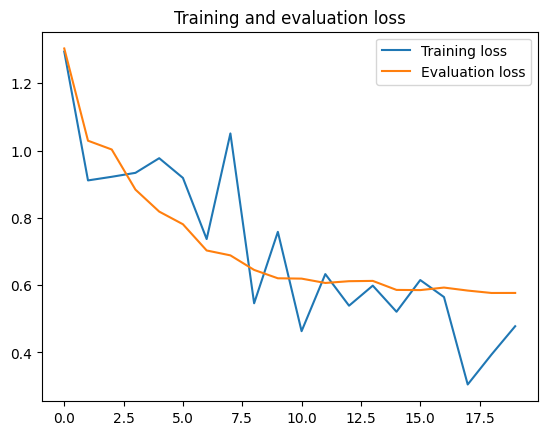

In [ ]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

* Loss measures the “goodness” of your model

* The smaller the loss, the better the classifier is at modeling the relationship between the input data and the output targets

* But you need to be careful not to overfit

In our case, we stopped training because eval_loss loss did not improve upon the best eval_loss by at least 0.01 for 2 consecutive evaluations.

We can observe fluctuations in the training loss, but overall it is decreasing.
We can have a smoother learning curve by varying hyperparameters, e.g., learning rate, batch size.

In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

{'mcc': 0.6636375709635199, 'eval_loss': 0.5768823325634003}

* mcc: [ Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)

* eval_loss: Cross Entropy Loss for dev

Make predictions with the model (predict the labels of the documents in the test set)

In [ ]:
predicted, probabilities = model.predict(test_df.text.to_list())
test_df['predicted'] = predicted

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Test set predictions

In [ ]:
test_df.head(10)

,text,topic,predicted
0,I wouldn't be caught dead watching the NFL if ...,0,2
1,Chris O'Donnell stated that while filming for ...,1,2
2,"The whole game was a rollercoaster ride, but L...",0,0
3,"Zendaya slayed in Dune 2, as she does in all h...",1,2
4,While my favorite player was playing this matc...,0,0
5,My uncle's brother's neighbor's cat's veterina...,2,1
6,He said that The Great Gatsby is the best nove...,2,1
7,I could not look away from this train wrck of ...,1,2
8,The film Everything Everywhere All At Once fol...,1,2
9,I just finished reading pride and prejudice wh...,2,1


Evaluate the model's performance on the test set

In [ ]:
# Result (note: your result can be different due to randomness in operations)
print(classification_report(test_df['topic'], test_df['predicted']))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3

    accuracy                           0.20        10
   macro avg       0.33      0.22      0.27        10
weighted avg       0.30      0.20      0.24        10



### End of this notebook.